In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from src.utilities import show_img
from scipy.signal import fftconvolve


In [16]:
def apply_gabor(img, theta, param=None):
    ksize = (31,31)
    sigma = 4
    lam = 10
    gamma = 0.5
    psi = 0
    ktype = cv2.CV_32F
    g_kernel = cv2.getGaborKernel(ksize, sigma, theta, lam , gamma, psi, ktype)
    g_kernel /= 1.5 * g_kernel.sum()
    out = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)
    # show_img(img, splt=131,title="Input")
    # show_img(g_kernel,splt=132,title="Filter")
    # show_img(out, splt=133,title="Filtered")
    # plt.show()
    return out, g_kernel


In [17]:
def gabor_pyramid(img, angles):
    accum = np.zeros_like(img)
    res = []
    n = len(angles)
    k=1
    plt.subplots_adjust(top=7,right=3)
    for angle in angles:
        # plt.figure()
        # plt.suptitle("theta = "+str(angle))
        fil,ker = apply_gabor(img,angle)
        np.maximum(accum, fil, accum)
        res.append(fil)
        show_img(img, splt=(n,3,k), title="input")
        show_img(ker, splt=(n,3,k+1), title="filter")
        show_img(fil, splt=(n,3,k+2), title="output")
        k+=3
    plt.show()
    return res,accum

In [18]:
def gabor_energy(img, theta):
    gab_0, _ = apply_gabor(img, theta)
    gab_90, _ = apply_gabor(img, theta, -np.pi/2)
    # print(img.ravel().shape, gab_90.ravel().shape)
    gab_i0 = fftconvolve(gab_0, img, 'same')
    gab_i90 = fftconvolve(gab_90, img, 'same')

    gab_i0 = gab_i0.reshape(gab_0.shape)
    gab_i90 = gab_i90.reshape(gab_90.shape)

    g_0 = np.sqrt(gab_i0 ** 2 + gab_i90 ** 2)
    return g_0

In [19]:
def get_gabor_vectors(img, norm=False):
    gs = []
    es = []
    H, W = img.shape
    vecs = np.zeros((H, W, 2))

    for i in range(4):
        energy = gabor_energy(img, i * np.pi/4)
        unit_vector = np.array([np.cos(i * np.pi/4), np.sin(i * np.pi/4)])
        gs.append(energy)
        es.append(unit_vector)
    # element-wise minimum matrix
    # m = np.minimum(*gs[0:3])
    # m = np.minimum(m, *gs[2:3])
    # m = np.minimum(m, gs[3])
    m = np.amin(gs, axis=0)
    # if np.all(md == m):
    #     print("okkokokoko")
    # exit(1)
    max_45_90 = np.maximum(*gs[1:3])
    is_135_gt = gs[3] > max_45_90
    g_ms = [(x - m) for x in gs]
    print(is_135_gt.shape)
    # print((g_ms[0].ravel() * es[0]).shape)
    for v in range(4):
        # vecs += g_ms[v] * es[v]
        if v == 0:
            mult = np.where(is_135_gt, -1, 1)
            temp = np.multiply(g_ms[0][:, :], mult)
            vecs[:, :, 0] += temp[:, :] * es[v][0]
            vecs[:, :, 1] += temp[:, :] * es[v][1]
        else:
            vecs[:, :, 0] += g_ms[v][:, :] * es[v][0]
            vecs[:, :, 1] += g_ms[v][:, :] * es[v][1]
     
    if norm:
        vecs /= (np.sum(vecs ** 2, axis=2) + 1e-2)[:, :, np.newaxis]

    print("nomredd")

    return vecs


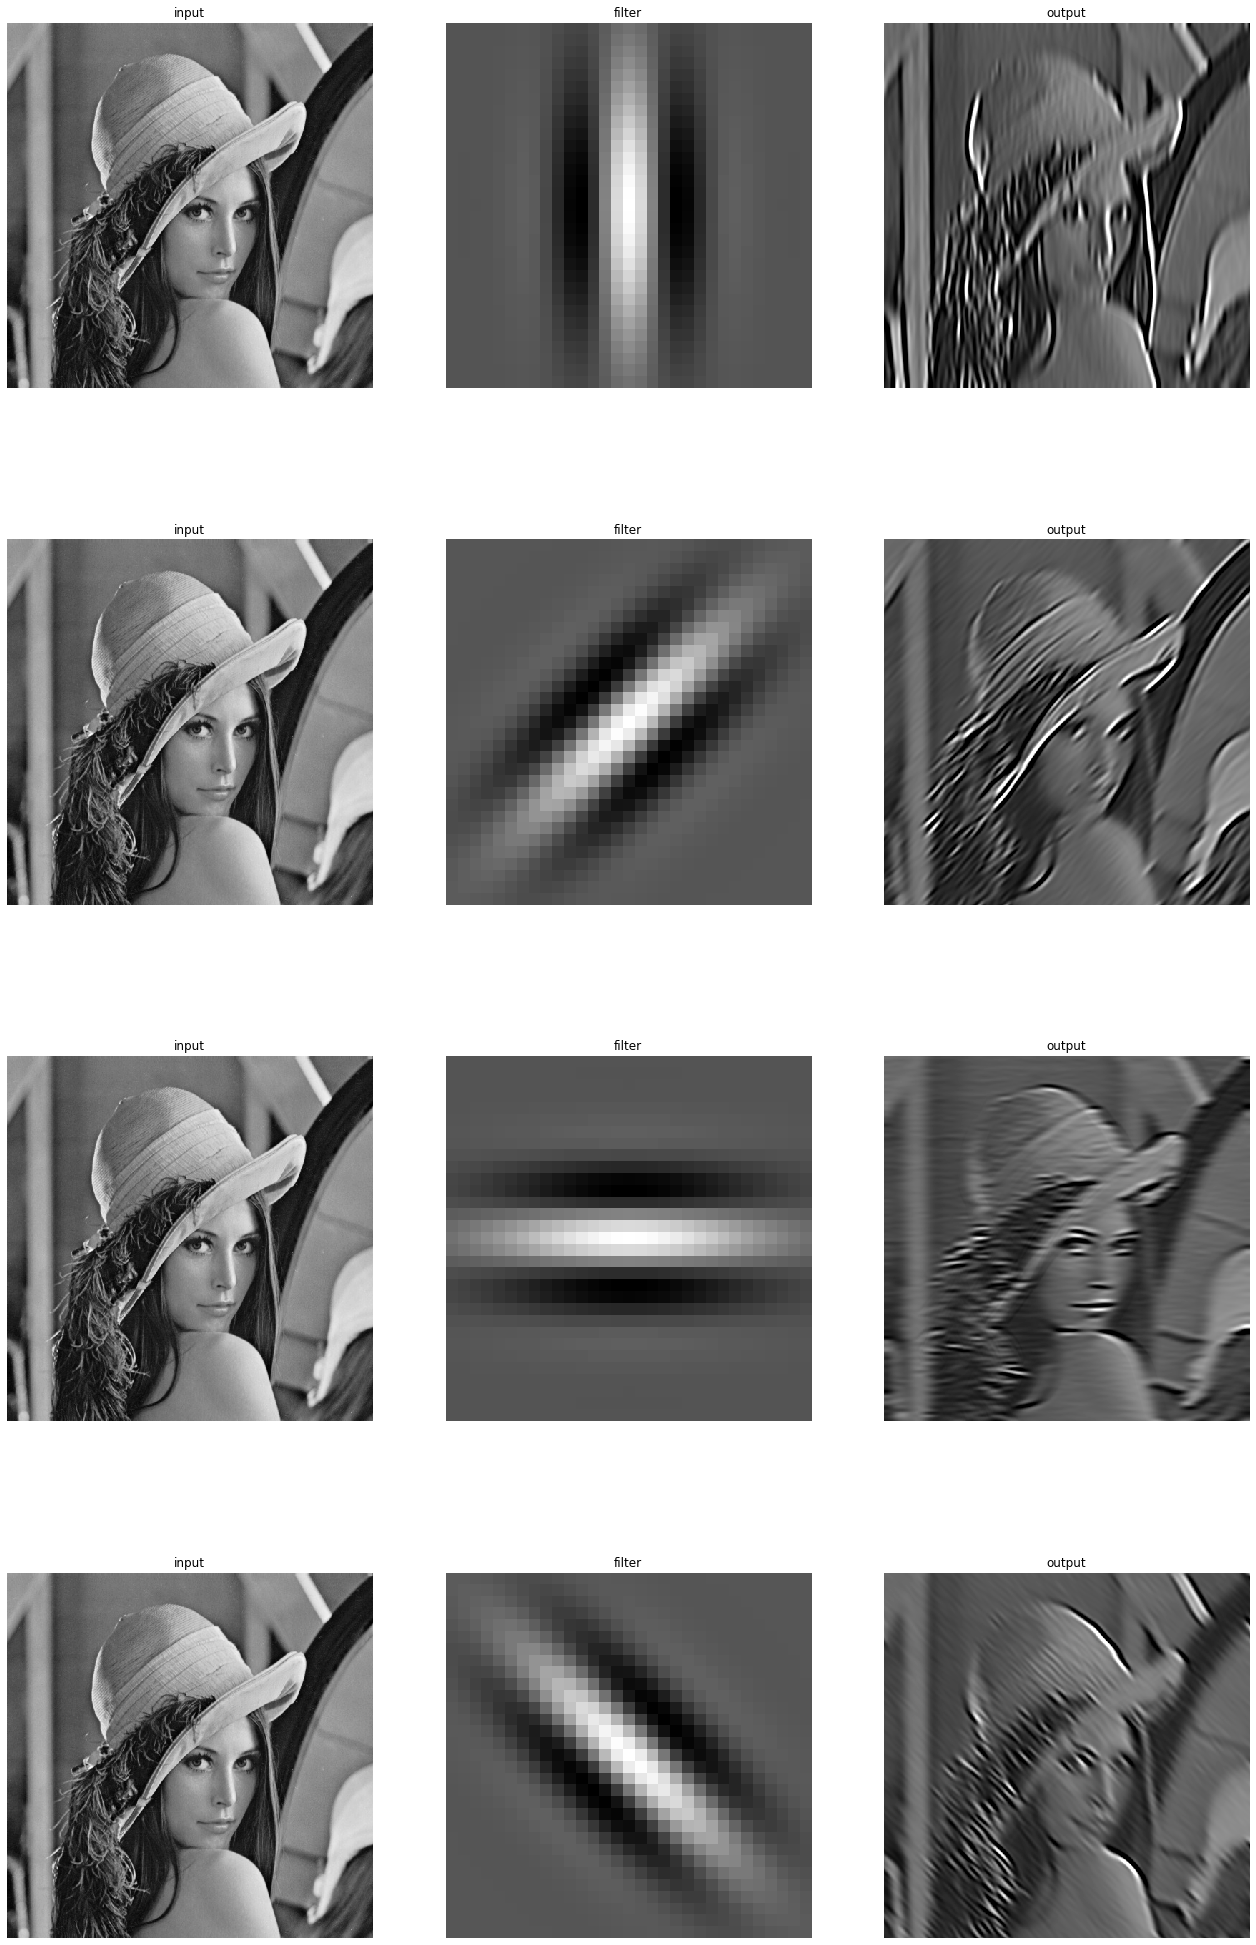

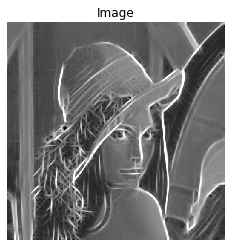

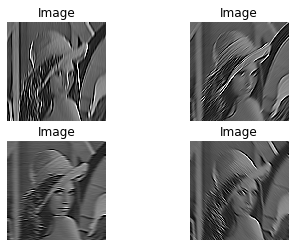

In [20]:
if __name__ == "__main__":
    img = cv2.imread('../images/lena.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # apply_gabor(img,None)
    angles = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        angles.append(theta)
    out,fin = gabor_pyramid(img, angles)
    plt.figure()
    cv2.imwrite("../images/out.png",fin)
    show_img(fin)
    
    plt.figure()
    for i in range(4):
        show_img(out[i], splt=221+i)

In [35]:
img = cv2.imread('../images/elephant.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)
vecs_gab = get_gabor_vectors(img,norm=True)

(242, 299)
(242, 299)
nomredd


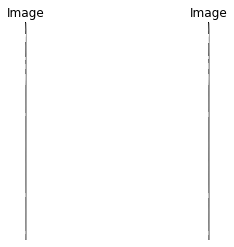

In [36]:
show_img(vecs_gab[0],splt=121)
show_img(vecs_gab[1],splt=122)

/home/sriteja/venv/dip/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


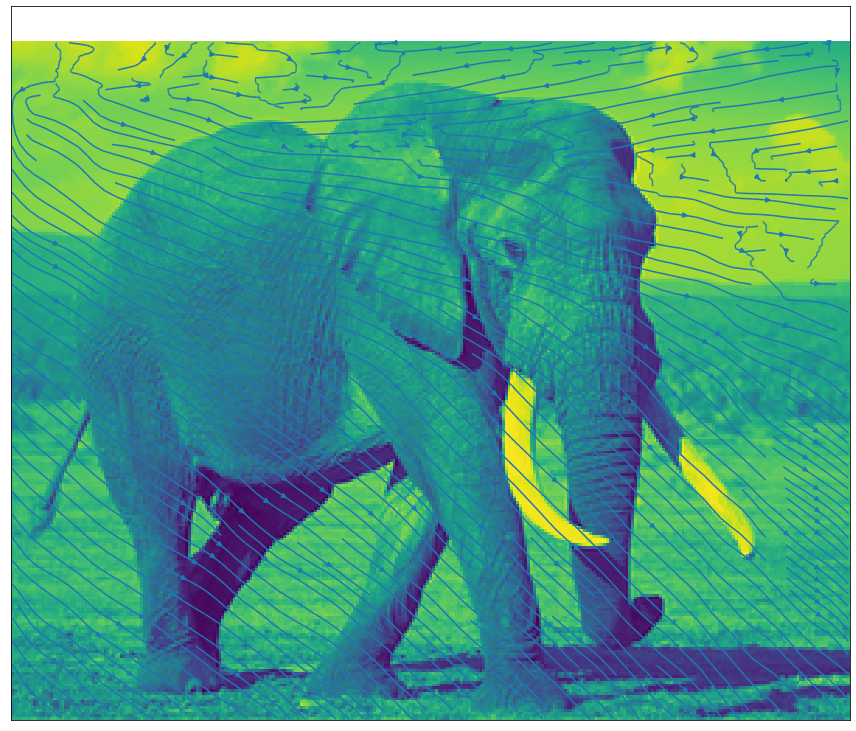

In [37]:
figure = plt.figure(figsize=(12,12))
plt.axes().get_xaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.imshow(img)
X, Y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
skip = 10
#plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], vec[::skip, ::skip, 1], vec[::skip, ::skip, 0])
plt.streamplot(X, Y, vecs_gab[:, :, 0], vecs_gab[:, :, 1], density=(2, 2))
plt.tight_layout()